# AA1 lab 05 - Discrminant analysis; warm-up with `iris` dataset

In [1]:
from sklearn.datasets import load_iris
import seaborn as sns
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.precision', 3)
np.set_printoptions(precision=3)

In [2]:
# load iris data and put it in a dataframe

iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['species'] = pd.Series([iris.target_names[y] for y in iris.target], dtype="category")
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## plot data using PCA


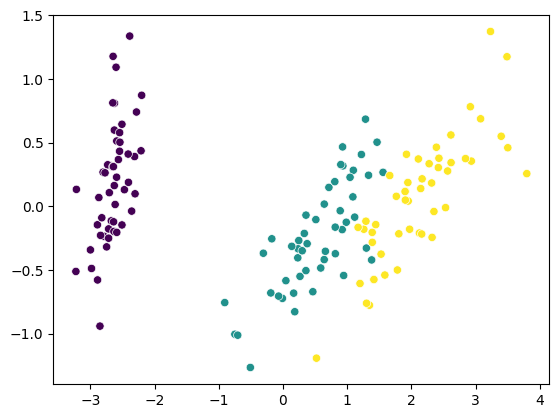

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(iris.data)
coords = pca.transform(iris.data)
sns.scatterplot(x=coords[:,0], y=coords[:,1], c=iris.target);

## drop some rows, to make it a little harder..

In [4]:
from collections import Counter

df = df.drop(df[df['species'] == 'setosa'].sample(frac=.9).index)   # remove 90% from setosa class
df = df.drop(df[df['species'] == 'versicolor'].sample(frac=.9).index)   # remove 70% from versicolor class
df = df.drop(df[df['species'] == 'virginica'].sample(frac=.9).index)   # remove 30% from virginica class

df.describe()

print(Counter(df['species']))

Counter({'setosa': 5, 'versicolor': 5, 'virginica': 5})


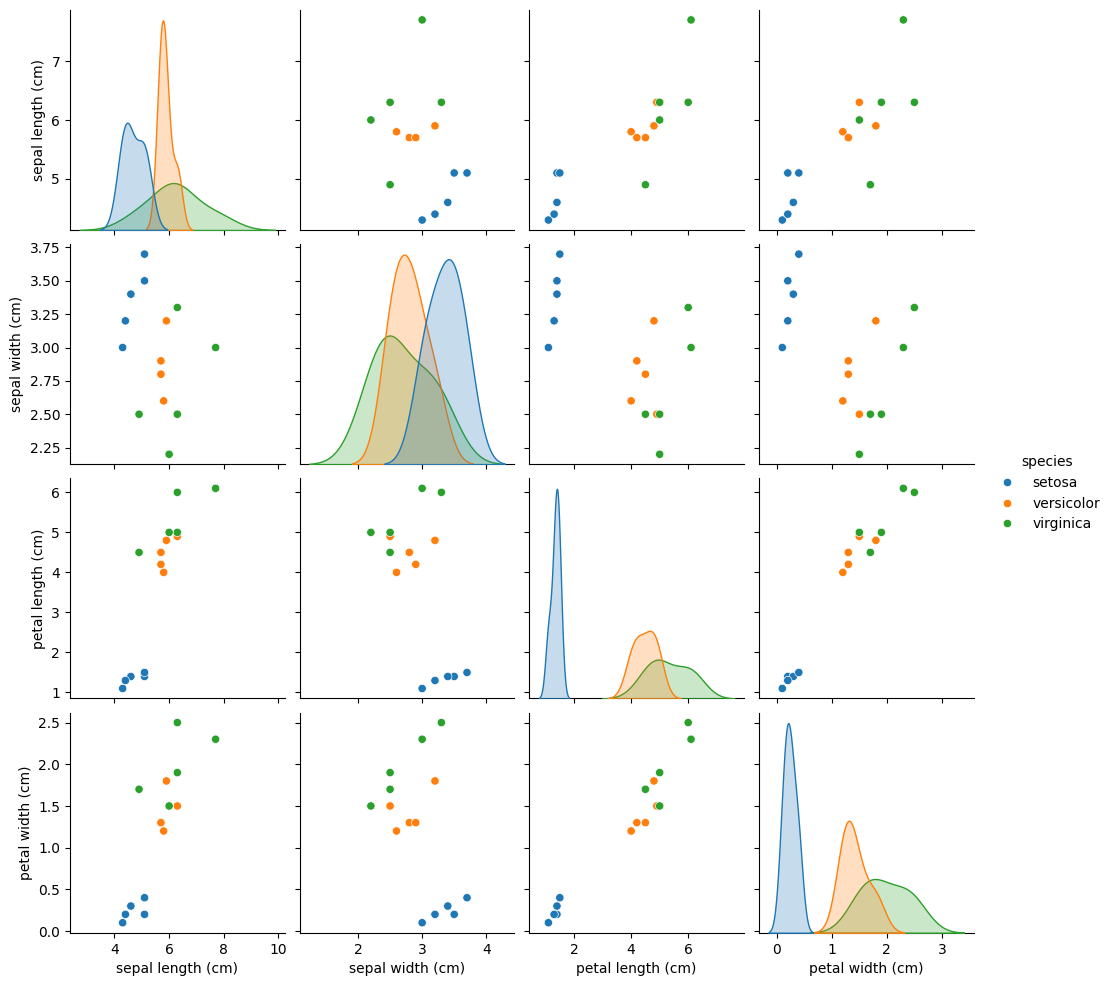

In [5]:
sns.pairplot(data=df, hue='species');

### QDA/LDA/RDA on `iris`

#### QDA
As a reminder, QDA implements the Bayesian classifier assuming $P(x|y=class)$ for each class is normally distributed. 
Hence, for $K$ classes it has to estimate their means $\mu_k$ and covariance matrices $\Sigma_k$ for $1\leq k\leq K$.

To predict, it uses the Bayesian rule $\hat{y}  = \argmax_k g_k(\mathbf{x})$ where

$$\begin{aligned}
g_k(\mathbf{x}) &= \log \left[P(y=c_k) P(\mathbf{x}| y = c_k)\right] \\
        &= \log \pi_k - \log (|2\pi\Sigma_k|^{\frac{1}{2}}) - \frac{1}{2}(\mathbf{x} - \mu_k)^T \Sigma_k^{-1}(\mathbf{x} - \mu_k) \\
        &= \log \pi_k - \frac{1}{2}\left(\log|\Sigma_k|  + (\mathbf{x} - \mu_k)^T \Sigma_k^{-1}(\mathbf{x} - \mu_k)\right)  + const
\end{aligned}$$

#### LDA
LDA is a special case of QDA where we assume all covariance matrices constant accross classes.
This simplifies the corresponding discriminant functions to:

$$g_k(\mathbf{x}) = \log \pi_k + \mu_k^T \Sigma^{-1}\mathbf{x} - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k$$

We can re-write $g_k(\mathbf{x}) = \theta_k^T \mathbf{x} + \theta_{k,0}$ using
- $\theta_k = \mu_k^T \Sigma^{-1}$
- $\theta_{k,0} = \log \pi_k + \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k$

These quantities correspond to the `coef_` and `_intercept` attributes of the object.


### QDA on `iris` data

In [6]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

X = iris.data
y = iris.target

qda = QuadraticDiscriminantAnalysis().fit(X, y)
y_pred = qda.predict(X)
cm_qda = confusion_matrix(y, y_pred)
print(cm_qda)

lda = LinearDiscriminantAnalysis().fit(X, y)
y_pred = lda.predict(X)
cm_lda = confusion_matrix(y, y_pred)
print(cm_lda)


[[50  0  0]
 [ 0 48  2]
 [ 0  1 49]]
[[50  0  0]
 [ 0 48  2]
 [ 0  1 49]]


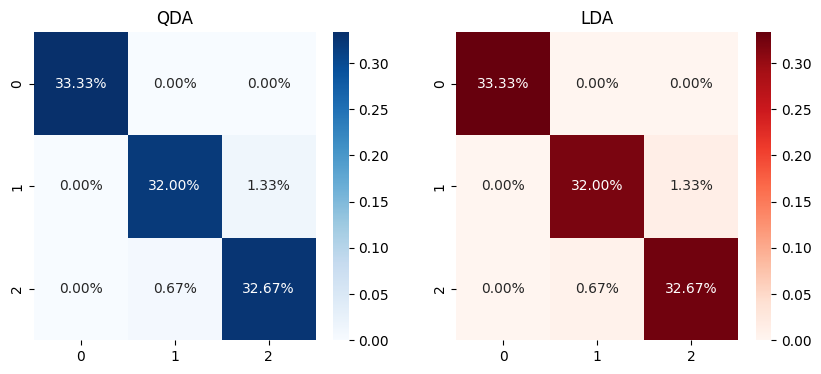

In [7]:
import matplotlib.pyplot as plt

# a little more appealing..

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_qda/np.sum(cm_qda), annot=True, fmt='.2%', cmap='Blues', ax=axs[0]);
axs[0].set_title('QDA');
sns.heatmap(cm_lda/np.sum(cm_lda), annot=True, fmt='.2%', cmap='Reds', ax=axs[1]);
axs[1].set_title('LDA');


### QDA/LDA/RDA by hand

In [8]:
# estimate priors, mean and covariances for each class

n_c = Counter(df['species'])   # nr of examples in each class
classes = list(n_c.keys())
n = sum(n_c.values())
d = len(iris.feature_names)

pi = {c:n_c[c] / n for c in classes}

mu = dict()   # to store means for each class
cov = dict()  # to store cov. matrices for each class
for c in classes:
    # get all examples from class c
    X_c = df.loc[df['species'] == c, iris.feature_names].to_numpy()
    mu[c] = np.mean(X_c, axis=0)
    cov[c] = np.cov(X_c, bias=False, rowvar=False)  # sample covariance matrix

for c in classes:
    print()
    print(f'class {c}:')
    print(f'\tprior: {pi[c]:.2f}')
    print(f'\tsample mean: {mu[c]}')
    print(f'\tsample cov matrix: {cov[c]}')


class setosa:
	prior: 0.33
	sample mean: [4.7  3.36 1.34 0.24]
	sample cov matrix: [[0.145 0.095 0.047 0.027]
 [0.095 0.073 0.039 0.027]
 [0.047 0.039 0.023 0.015]
 [0.027 0.027 0.015 0.013]]

class versicolor:
	prior: 0.33
	sample mean: [5.88 2.8  4.48 1.42]
	sample cov matrix: [[ 0.062 -0.03   0.067  0.026]
 [-0.03   0.075  0.017  0.04 ]
 [ 0.067  0.017  0.147  0.073]
 [ 0.026  0.04   0.073  0.057]]

class virginica:
	prior: 0.33
	sample mean: [6.24 2.7  5.32 1.98]
	sample cov matrix: [[0.998 0.212 0.584 0.246]
 [0.212 0.195 0.257 0.18 ]
 [0.584 0.257 0.487 0.253]
 [0.246 0.18  0.253 0.172]]


### estimate sample cov matrix for LDA 

$$\hat{\Sigma} = \frac{1}{n-K}\sum_{k=1}^K (n_k -1)\hat{\Sigma}_k$$

In [9]:
lda_cov = np.zeros((d,d))
for c in classes:
    lda_cov += cov[c] * (n_c[c]-1)
lda_cov /= (n - len(classes))
print(lda_cov)

[[0.402 0.092 0.233 0.1  ]
 [0.092 0.114 0.105 0.082]
 [0.233 0.105 0.219 0.114]
 [0.1   0.082 0.114 0.081]]


In [10]:
import scipy.stats

# make prediction for QDA using $y_pred = argmax_k g_k(x)$

x = (mu['versicolor'] + mu['virginica']) / 2

g = dict()
for c in classes:
    g[c] = np.log(pi[c]) + scipy.stats.multivariate_normal.logpdf(x, mean=mu[c], cov=cov[c])
print(f'predictions for QDA: {Counter(g).most_common()}')

for c in classes:
    g[c] = np.log(pi[c]) + scipy.stats.multivariate_normal.logpdf(x, mean=mu[c], cov=lda_cov)
print(f'predictions for LDA: {Counter(g).most_common()}')

predictions for QDA: [('versicolor', -9.773300811672064), ('virginica', -39.40386083441416), ('setosa', -2131197.9067078843)]
predictions for LDA: [('versicolor', -1.7708922230345328), ('virginica', -1.7708922230345328), ('setosa', -109.46397154388261)]


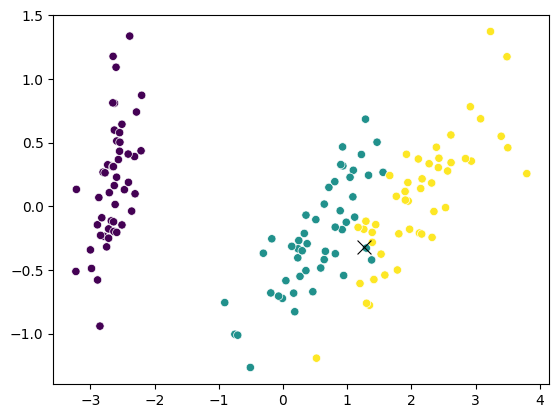

In [11]:
# show location of query point x

xy = pca.transform(x.reshape(1, -1))
ax = sns.scatterplot(x=coords[:,0], y=coords[:,1], c=iris.target, legend='auto');
sns.scatterplot(x=xy[:,0], y=xy[:,1], c=['black'], s=100, ax = ax, marker='x');

__Exercise:__ Implement _Gaussian NB_  classifier and compute predictions on previous $x$